<a href="https://colab.research.google.com/github/science0229/19Fall_EE531-1-/blob/master/2019_Fall_EE531_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2019 Fall EE531 Assignment #4

A significant portion of the code has been reordered and a bit modified.

(Style of coding has been largely inspired by coding assignments from CS470: Introduction to Artificial Intelligence)

## Step 1: Connect to my Google Drive

Required to save checkpoints and load them later on.

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

## Step 2: Install Dependencies (Python Packages)

In [0]:
!pip install --upgrade pip
!pip install numpy
!pip install scipy
!pip install torch

## Step 3: Import Necessary Python Modules

In [18]:
import os

import argparse
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

import numpy as np
import scipy.sparse as sp

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


## Step 4: Configure the experiments

In [19]:
# Training settings (You can modify to get your best results)
EPOCHS = 200
LR = 0.01
WEIGHT_DECAY = 5e-4
HIDDEN = 16
#DROPOUT = 0
DROPOUT = 0.5

CUDA = torch.cuda.is_available()
device = 'cuda'

# Boolean value to select training process
#training_process=True

# Seeding process for recreation of results
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)


# Initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://27813729.ngrok.io


## Step 5: Download CORA dataset

In [20]:
!git clone https://github.com/hobincar/EE531-HW4-dataset.git data

fatal: destination path 'data' already exists and is not an empty directory.


## Step 6: Define Utility Functions
   * `encode_onehot(labels)`: Encode `labels` into one-hot vectors.
   * `load_data(path, dataset)`: Load `dataset` from the directory in `path`.
   * `normalize(mtx)`: Normalize a matrix `mtx` row-wise.
   * `sparse_mx_to_torch_sparse_tensor(sparse_mx)`: Convert a scipy sparse matrix `sparse_mx` to a torch sparse tensor.
   * `accuracy(output, labels)`: Measure accuracy by comparing the predicted logits `output` with the ground-truth labels `labels`.
  

In [0]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(path="./data/cora/", dataset="cora"):
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 2708)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test


def normalize(mtx):
    rowsum = np.array(mtx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mtx = r_mat_inv.dot(mtx)
    return mtx


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

## Step 7: Define Graph Convolutional Layer
Graph Convolution Layer is a building block of Graph Convolutional Network which will be defined in the next section.

In [0]:
class GraphConvolutionLayer(nn.Module):
    """
      A Graph Convolution Layer.

      ...

      Attributes
      ----------
      weight : torch.nn.Parameter
          a weight parameter matrix of the Graph Convolution Layer.
      bias : torch.nn.Parameter
          a bias parameter vector of the Graph Convolution Layer.

      Methods
      -------
      __init__(self, in_features, out_features, bias=True)
          Initialize the Graph Convolution Layer by declaring and initializing
          its weight and bias.
      init_parameters(self)
          Randomly initialize its parameters (weight and bias).
      forward(self, input, adj)
          Forward propagation of the Graph Convolution Layer.
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolutionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.init_parameters()

    def init_parameters(self):
        # ========= YOU CODE HERE =========
        # Initializing weight and bias
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
        # =================================

    def forward(self, input, adj):
        # ========= YOU CODE HERE =========
        # Convolving your input graph with your weight corresponding adjacent 
        # matrix, don't forget to add bias
        s = torch.mm(input, self.weight)
        out = torch.mm(adj, s) + self.bias
        # =================================
        return out


## Step 8: Define Graph Convolutional Network

In [0]:
class GCN(nn.Module):
    """
      A Graph Convolutional Network.

      ...

      Attributes
      ----------
      gc<i> : GraphConvolutionLayer
          a <i>-th Graph Convolution Layer.
          e.g. gc1, gc2, gc3, ...

      Methods
      -------
      __init__(self, nfeat, nhid, nclass, dropout)
          Initialize the Graph Convolutional Network by declaring Graph
          Convolution Layers.
      forward(self, input, adj)
          Forward propagation of the Graph Convolutional Network.
    """
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        # ========= YOU CODE HERE =========
        # Declaring your multiple graph convolution layers, remembering that
        # output of final layer has dimension equal to number of classes
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2 = GraphConvolutionLayer(nhid, nclass)
        self.dropout = dropout
        # =================================

    def forward(self, x, adj):
        # ========= YOU CODE HERE =========
        # Feeding your input graph and adjacent matrix into multiple graph 
        # convolution layers and activation function
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training = self.training)
        x = self.gc2(x, adj)
        # =================================
        out = F.log_softmax(x, dim=1)
        return out

## Step 9: Load dataset & Initialize the network and optimizer

In [24]:
# Loading graph dataset
adj, features, labels, idx_train, idx_val, idx_test = load_data()

if CUDA:
    features = features.to(device)
    adj = adj.to(device)
    labels = labels.to(device)
    idx_train = idx_train.to(device)
    idx_val = idx_val.to(device)
    idx_test = idx_test.to(device)
  

# GCN Model
model = GCN(nfeat = features.shape[1],
            nhid = HIDDEN,
            nclass = labels.max().item() + 1,
            dropout = DROPOUT)
if CUDA:
  model = model.to(device)

# Print the model
print(model)

optimizer = optim.Adam(model.parameters(),
                       lr=LR, weight_decay=WEIGHT_DECAY)

Loading cora dataset...
GCN(
  (gc1): GraphConvolutionLayer()
  (gc2): GraphConvolutionLayer()
)


## Step 10: Load pre-trained weights if it exists

In [0]:
ckpt_dir = os.path.join(gdrive_root, 'EE531_checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
acc_best = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    acc_best = ckpt['acc_best']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' %acc_best)

## Step 11: Train GCN

In [26]:
def train(epoch, model, acc_best):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    # ========= YOU CODE HERE =========
    # Feeding your input graph (nodes's feature and adjacent matrix) into your
    # model and computing loss between prediction and ground truth
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])

    # Update the tensorboard plot
    tbc.save_value('Loss',' train_loss', epoch, loss_train.item())
    # =================================

    acc_train = accuracy(output[idx_train], labels[idx_train])
    # Update the tensorboard plot
    tbc.save_value('Accuracy',' train_accuracy', epoch, acc_train.item())

    loss_train.backward()
    optimizer.step()


    ## Validation phase!

    # Evaluate validation set performance separately.
    model.eval()
    
    # ========= YOU CODE HERE =========
    # Computing loss for validation set
    output = model(features, adj)
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])

    # Update the tensorboard plot
    tbc.save_value('Loss',' validation loss', epoch, loss_val.item())

    tbc.flush_line('train loss')
    tbc.flush_line('validation loss')
    # =================================
    acc_val = accuracy(output[idx_val], labels[idx_val])
    # Update the tensorboard plot
    tbc.save_value('Accuracy',' validation accuracy', epoch, acc_val.item())


    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    # Save checkpoint whenever there is improvement in performance
    if acc_val > acc_best:
      acc_best = acc_val
      # Note: optimizer also has states! Don't forget to save them as well.
      ckpt = {'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'acc_best': acc_best}
      torch.save(ckpt, ckpt_path)
      print('Checkpoint is saved!')


# Train model
t_total = time.time()
for epoch in range(EPOCHS):
    train(epoch, model, acc_best)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))


#tbc.close()

Epoch: 0001 loss_train: 1.9782 acc_train: 0.1071 loss_val: 1.9659 acc_val: 0.1100 time: 0.0121s
Checkpoint is saved!
Epoch: 0002 loss_train: 1.9650 acc_train: 0.0929 loss_val: 1.9512 acc_val: 0.1333 time: 0.0071s
Checkpoint is saved!
Epoch: 0003 loss_train: 1.9464 acc_train: 0.1214 loss_val: 1.9360 acc_val: 0.1100 time: 0.0068s
Checkpoint is saved!
Epoch: 0004 loss_train: 1.9404 acc_train: 0.1000 loss_val: 1.9206 acc_val: 0.1167 time: 0.0068s
Checkpoint is saved!
Epoch: 0005 loss_train: 1.9188 acc_train: 0.1714 loss_val: 1.9051 acc_val: 0.1133 time: 0.0066s
Checkpoint is saved!
Epoch: 0006 loss_train: 1.9197 acc_train: 0.1643 loss_val: 1.8899 acc_val: 0.3533 time: 0.0067s
Checkpoint is saved!
Epoch: 0007 loss_train: 1.8834 acc_train: 0.2929 loss_val: 1.8746 acc_val: 0.3500 time: 0.0073s
Checkpoint is saved!
Epoch: 0008 loss_train: 1.8711 acc_train: 0.2857 loss_val: 1.8595 acc_val: 0.3500 time: 0.0065s
Checkpoint is saved!
Epoch: 0009 loss_train: 1.8593 acc_train: 0.2929 loss_val: 1.844

## Step 12: Test the Trained GCN

In [27]:
def test(model):
    model.eval()
    # ========= YOU CODE HERE =========
    # Feeding your input graph into your model and computing loss
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    # =================================
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
# Testing
test(model)

Test set results: loss= 0.7931 accuracy= 0.7840


## Step 13: Additional visualization: confusion matrix, learning/performance curves

*   *Case Based* ----> class A
*   *Genetic Algorithms* ----> class B
*   *Neural Networks* ----> class C
*   *Probabilistic Methods* ----> class D
*   *Reinforcement Learning* ----> class E
*   *Rule Learning* ----> class F
*   *Theory* ----> class G

In [0]:
# Source: https://github.com/wcipriano/pretty-print-confusion-matrix

# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
import seaborn as sn
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.

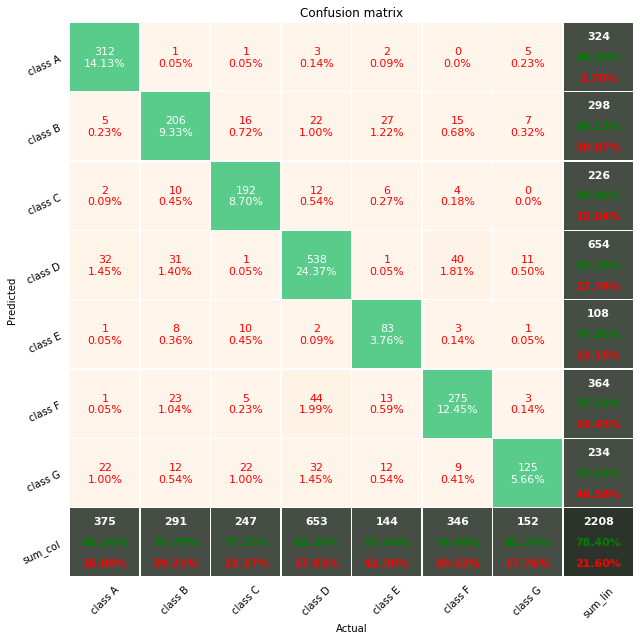

In [29]:
from sklearn.metrics import confusion_matrix


with torch.no_grad():
  true = labels[idx_test].cpu().numpy()
  predicted = model(features, adj)[idx_test].max(1)[1].type_as(labels).cpu().numpy()

columns = []
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12;
figsize = [9,9];
if(len(true) > 10):
    fz=9; figsize=[14,14];
plot_confusion_matrix_from_data(true, predicted, columns,
  annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)


#cf = confusion_matrix(true, predicted)
#print(cf)

#df_cm = pd.DataFrame(cf, index = [i for i in "ABCDEFG"],
#                  columns = [i for i in "ABCDEFG"])
#cmap = 'PuRd'
#pretty_plot_confusion_matrix(df_cm, cmap=cmap)

#plt.figure(figsize = (10,7))
# for label size
#sn.set(font_scale=1.4)
# for font size
#sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})